In [108]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

import glob, os
import keras

from keras import layers
from keras.models import Model
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa

import random

# Veri Önişleme


In [109]:
def extract_label(img_path):
    filename, _ = os.path.splitext(os.path.basename(img_path))

    subject_id, etc = filename.split('__')
    gender, lr, finger, *_ = etc.split('_')

    gender = 0 if gender == 'M' else 1
    lr = 0 if lr =='Left' else 1

    finger_mapping = {'thumb': 0, 'index': 1, 'middle': 2, 'ring': 3, 'little': 4}
    finger = finger_mapping.get(finger, -1)

    return np.array([subject_id, gender, lr, finger], dtype=np.uint16)


def extract_label2(img_path):
    filename, _ = os.path.splitext(os.path.basename(img_path))

    subject_id, etc = filename.split('__')
    gender, lr, finger, *_ = etc.split('_')

    gender = 0 if gender == 'M' else 1
    lr = 0 if lr == 'Left' else 1

    finger_mapping = {'thumb': 0, 'index': 1, 'middle': 2, 'ring': 3, 'little': 4}
    finger = finger_mapping.get(finger, -1)

    return np.array([subject_id, gender, lr, finger], dtype=np.uint16)

In [110]:
from pathlib import Path

def process_image_folder(input_folder, output_x, output_y, label_extraction_function):
    img_list = sorted(Path(input_folder).glob('*.BMP'))
    print(len(img_list))

    imgs = np.array([cv2.resize(cv2.imread(str(img), cv2.IMREAD_GRAYSCALE), (96, 96)) for img in img_list], dtype=np.uint8)
    labels = np.array([label_extraction_function(str(img)) for img in img_list], dtype=np.uint16)

    np.save(output_x, imgs)
    np.save(output_y, labels)

In [111]:
# Real klasörü için extract_label fonksiyonunu kullan
process_image_folder('VeriSeti/Real', 'dataset/x_real.npy', 'dataset/y_real.npy', extract_label)

# Diğer klasörler için extract_label2 fonksiyonunu kullan
process_image_folder('VeriSeti/Altered/Altered-Easy', 'dataset/x_easy.npy', 'dataset/y_easy.npy', extract_label2)
process_image_folder('VeriSeti/Altered/Altered-Medium', 'dataset/x_medium.npy', 'dataset/y_medium.npy', extract_label2)
plt.show()

6000
17931
17067


# Train

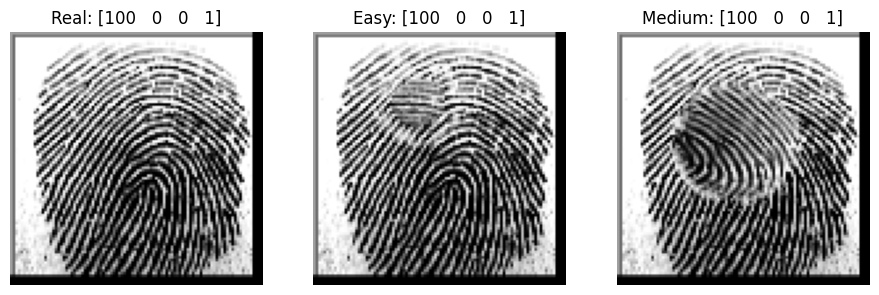

In [112]:
# Veriyi yükleyin
x_real = np.load('dataset/x_real.npy')
y_real = np.load('dataset/y_real.npy')

x_easy = np.load('dataset/x_easy.npy')
y_easy = np.load('dataset/y_easy.npy')

x_medium = np.load('dataset/x_medium.npy')
y_medium = np.load('dataset/y_medium.npy')


def show_image_with_label(image, label, class_name, subplot_index):
    plt.subplot(1, 4, subplot_index)
    plt.title(f"{class_name}: {label}")
    plt.imshow(image.squeeze(), cmap='gray')
    plt.axis('off')

class_labels = {0: 'Real', 1: 'Easy', 2: 'Medium'}

# Görselleri gösterme
plt.figure(figsize=(15, 10))

# Real, Easy, Medium, Hard sırasıyla
datasets = [(x_real, y_real, 'Real'), (x_easy, y_easy, 'Easy'), (x_medium, y_medium, 'Medium')]

for i, (x, y, class_name) in enumerate(datasets, start=1):
    show_image_with_label(x[0], y[0], class_name, i)

plt.show()

In [113]:
x_data = np.concatenate([x_easy, x_medium], axis=0)
label_data = np.concatenate([y_easy, y_medium], axis=0)


x_train, x_val, label_train, label_val = train_test_split(x_data, label_data, test_size=0.1)

print(x_data.shape, label_data.shape)
print(x_train.shape, label_train.shape)
print(x_val.shape, label_val.shape)

(34998, 96, 96) (34998, 4)
(31498, 96, 96) (31498, 4)
(3500, 96, 96) (3500, 4)


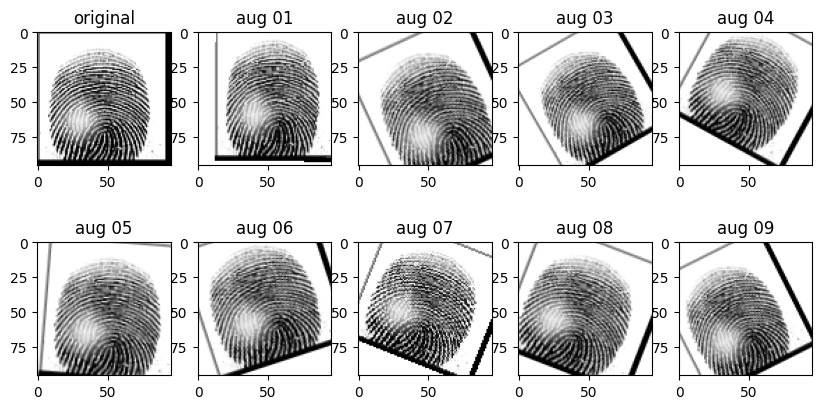

In [114]:
augs = [x_data[33]] * 9

seq = iaa.Sequential([
    # blur images with a sigma of 0 to 0.5
    iaa.GaussianBlur(sigma=(0, 0.5)),
    iaa.Affine(
        # scale images to 90-110% of their size, individually per axis
        scale={"x": (0.9, 1.1), "y": (0.9, 1.1)},
        # translate by -10 to +10 percent (per axis)
        translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
        # rotate by -30 to +30 degrees
        rotate=(-30, 30),
        # use nearest neighbour or bilinear interpolation (fast)
        order=[0, 1],
        # if mode is constant, use a cval between 0 and 255
        cval=255
    )
], random_order=True)

augs = seq.augment_images(augs)

plt.figure(figsize=(10, 5))
plt.subplot(2, 5, 1)
plt.title('original')
plt.imshow(x_data[33].squeeze(), cmap='gray')
for i, aug in enumerate(augs):
    plt.subplot(2, 5, i+2)
    plt.title('aug %02d' % int(i+1))
    plt.imshow(aug.squeeze(), cmap='gray')

In [115]:
label_real_dict = {}

for i, y in enumerate(y_real):
    key = y.astype(str)
    key = ''.join(key).zfill(6)

    label_real_dict[key] = i

In [116]:
import tensorflow as tf
class DataGenerator(keras.utils.Sequence):
    def __init__(self, x, label, x_real, label_real_dict, batch_size=32, shuffle=True, **kwargs):
        super().__init__(**kwargs)
        self.x = x
        self.label = label
        self.x_real = x_real
        self.label_real_dict = label_real_dict

        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):  #Her epochtaki batch sayısı
        return int(np.floor(len(self.x) / self.batch_size))

    def __getitem__(self, index):
        #Batch indexleri oluşturma
        x1_batch = self.x[index*self.batch_size:(index+1)*self.batch_size]
        label_batch = self.label[index*self.batch_size:(index+1)*self.batch_size]

        x2_batch = np.empty((self.batch_size, 96, 96, 1), dtype=np.float32)
        y_batch = np.zeros((self.batch_size, 1), dtype=np.float32)

        if self.shuffle: #veri genişletme
            seq = iaa.Sequential([
                iaa.GaussianBlur(sigma=(0, 0.5)),
                iaa.Affine(
                    scale={"x": (0.9, 1.1), "y": (0.9, 1.1)},
                    translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
                    rotate=(-30, 30),
                    order=[0, 1],
                    cval=255
                )
            ], random_order=True)

            x1_batch = seq.augment_images(x1_batch)


        for i, l in enumerate(label_batch): ## Eşleşen resimleri (label 1.0) ve eşleşmeyen resimleri (label 0.0) seçip bir araya getirir.
            match_key = l.astype(str)
            match_key = ''.join(match_key).zfill(6)

            if random.random() > 0.5: #Eşleşen resim
                x2_batch[i, :, :, 0] = self.x_real[self.label_real_dict[match_key]].reshape((96, 96))
                y_batch[i] = 1.

            else:  #Eşleşmeyen resim
                while True:
                    unmatch_key, unmatch_idx = random.choice(list(self.label_real_dict.items()))

                    if unmatch_key != match_key:
                        break

                x2_batch[i, :, :, 0] = self.x_real[unmatch_idx].reshape((96, 96))
                y_batch[i] = 0.

        x1_batch_tensor = tf.convert_to_tensor(x1_batch.astype(np.float32) / 255.)
        x2_batch_tensor = tf.convert_to_tensor(x2_batch.astype(np.float32) / 255.)
        y_batch_tensor = tf.convert_to_tensor(y_batch)
        
        # Görselleri [0,1] arasında normalize ediyor
        return (x1_batch_tensor, x2_batch_tensor), y_batch_tensor

    def on_epoch_end(self):
        if self.shuffle == True:
            self.x, self.label = shuffle(self.x, self.label)

In [117]:
train_gen = DataGenerator(x_train, label_train, x_real, label_real_dict, shuffle=True)
val_gen = DataGenerator(x_val, label_val, x_real, label_real_dict, shuffle=False)

In [118]:
from keras.models import Model
from keras import layers

# Giriş boyutu 96x96
x1 = layers.Input(shape=(96, 96, 1))
x2 = layers.Input(shape=(96, 96, 1))

inputs = layers.Input(shape=(96, 96, 1))

# Özellik çıkarma katmanları
feature = layers.Conv2D(32, kernel_size=3, padding='same', activation='relu')(inputs)
feature = layers.MaxPooling2D(pool_size=2)(feature)

feature = layers.Conv2D(32, kernel_size=3, padding='same', activation='relu')(feature)
feature = layers.MaxPooling2D(pool_size=2)(feature)

feature_model = Model(inputs=inputs, outputs=feature) # Özellik modeli
x1_net = feature_model(x1)
x2_net = feature_model(x2)

net = layers.Subtract()([x1_net, x2_net]) # Özellik çıkartma

# Ek özellik çıkarma katmanları
net = layers.Conv2D(32, kernel_size=3, padding='same', activation='relu')(net)
net = layers.MaxPooling2D(pool_size=2)(net)

net = layers.Flatten()(net)  # Düzleştir
net = layers.Dense(64, activation='relu')(net) # Tam bağlantılı katmanlar
net = layers.Dense(1, activation='sigmoid')(net) # Çıkış katmanı


model = Model(inputs=[x1, x2], outputs=net) # Modeli derle
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

model.summary()


Model: "functional_23"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_15      │ (None, 96, 96, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_16      │ (None, 96, 96, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_21       │ (None, 24, 24,    │      9,568 │ input_layer_15[0… │
│ (Functional)        │ 32)               │            │ input_layer_16[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ subtract_5          │ (None, 24, 24,    │          0 │ functional_21[0]… │
│ (Subtract)          │ 32)               │            │ functional_21[1]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 24, 24,    │      9,248 │ subtract_5[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_17    │ (None, 12, 12,    │          0 │ conv2d_17[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_5 (Flatten) │ (None, 4608)      │          0 │ max_pooling2d_17… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 64)        │    294,976 │ flatten_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 1)         │         65 │ dense_10[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 313,857 (1.20 MB)

 Trainable params: 313,857 (1.20 MB)

 Non-trainable params: 0 (0.00 B)

In [119]:
history = model.fit(train_gen, epochs=30, validation_data=val_gen)

Epoch 1/30
984/984 ━━━━━━━━━━━━━━━━━━━━ 87s 87ms/step - acc: 0.8423 - loss: 0.3260 - val_acc: 0.9860 - val_loss: 0.0842
Epoch 2/30
984/984 ━━━━━━━━━━━━━━━━━━━━ 88s 89ms/step - acc: 0.9510 - loss: 0.1309 - val_acc: 0.9897 - val_loss: 0.0372
Epoch 3/30
984/984 ━━━━━━━━━━━━━━━━━━━━ 86s 88ms/step - acc: 0.9658 - loss: 0.0917 - val_acc: 0.9957 - val_loss: 0.0192
Epoch 4/30
984/984 ━━━━━━━━━━━━━━━━━━━━ 85s 86ms/step - acc: 0.9745 - loss: 0.0741 - val_acc: 0.9943 - val_loss: 0.0205
Epoch 5/30
984/984 ━━━━━━━━━━━━━━━━━━━━ 86s 87ms/step - acc: 0.9761 - loss: 0.0692 - val_acc: 0.9900 - val_loss: 0.0264
Epoch 6/30
984/984 ━━━━━━━━━━━━━━━━━━━━ 85s 86ms/step - acc: 0.9791 - loss: 0.0622 - val_acc: 0.9977 - val_loss: 0.0084
Epoch 7/30
984/984 ━━━━━━━━━━━━━━━━━━━━ 85s 87ms/step - acc: 0.9810 - loss: 0.0533 - val_acc: 0.9914 - val_loss: 0.0269
Epoch 8/30
984/984 ━━━━━━━━━━━━━━━━━━━━ 87s 89ms/step - acc: 0.9791 - loss: 0.0554 - val_acc: 0.9977 - val_loss: 0.0106
Epoch 9/30
984/984 ━━━━━━━━━━━━━━━━━━━━ 

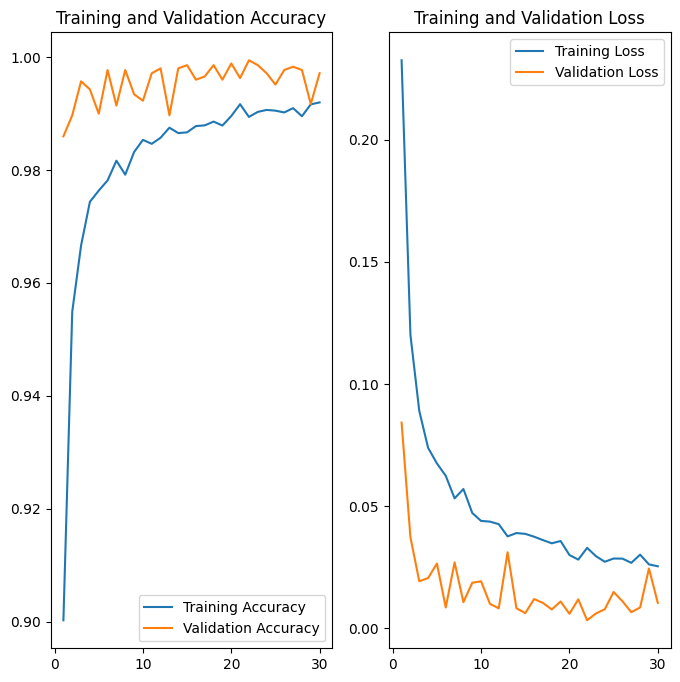

In [120]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, len(val_loss) + 1)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Test


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


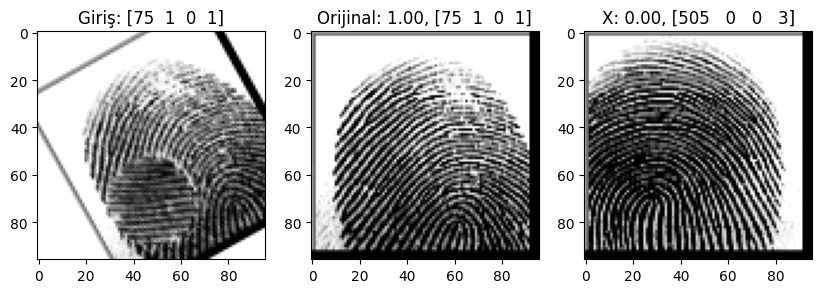

In [121]:
# new user fingerprint input
random_idx = random.randint(0, len(x_val))

random_img = x_val[random_idx]
random_label = label_val[random_idx]

seq = iaa.Sequential([
    iaa.GaussianBlur(sigma=(0, 0.5)),
    iaa.Affine(
        scale={"x": (0.9, 1.1), "y": (0.9, 1.1)},
        translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
        rotate=(-30, 30),
        order=[0, 1],
        cval=255
    )
], random_order=True)

random_img = seq.augment_image(random_img).reshape((1, 96, 96, 1)).astype(np.float32) / 255.

# matched image
match_key = random_label.astype(str)
match_key = ''.join(match_key).zfill(6)

rx = x_real[label_real_dict[match_key]].reshape((1, 96, 96, 1)).astype(np.float32) / 255.
ry = y_real[label_real_dict[match_key]]

pred_rx = model.predict([random_img, rx])

# unmatched image
unmatch_key, unmatch_idx = random.choice(list(label_real_dict.items()))

ux = x_real[unmatch_idx].reshape((1, 96, 96, 1)).astype(np.float32) / 255.
uy = y_real[unmatch_idx]

pred_ux = model.predict([random_img, ux])

plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.title('Giriş: %s' %random_label)
plt.imshow(random_img.squeeze(), cmap='gray')
plt.subplot(1, 3, 2)
plt.title('Orijinal: %.02f, %s' % (pred_rx.item(), ry))  # Use .item() to get the scalar value
plt.imshow(rx.squeeze(), cmap='gray')
plt.subplot(1, 3, 3)
plt.title('X: %.02f, %s' % (pred_ux.item(), uy))  # Use .item() to get the scalar value
plt.imshow(ux.squeeze(), cmap='gray')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


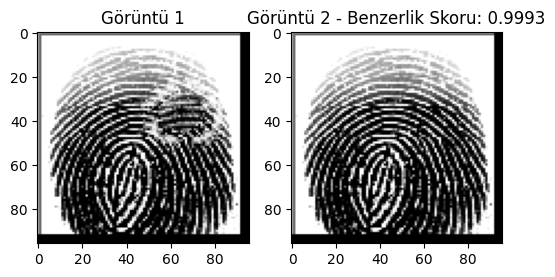

In [122]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
import numpy as np


# Görsel yollarını belirtin
image_path1 = "VeriSeti/Altered/Altered-Easy/1__M_Left_index_finger_CR.BMP"
image_path2 = "VeriSeti/Real/1__M_Left_index_finger.BMP"

# Görselleri yükleyin
img1 = image.load_img(image_path1, target_size=(96, 96), color_mode='grayscale')
img2 = image.load_img(image_path2, target_size=(96, 96), color_mode='grayscale')

# Görselleri diziye dönüştürün
img_array1 = image.img_to_array(img1) / 255.0
img_array2 = image.img_to_array(img2) / 255.0

# Diziyi modele uygun formata getirin
img_array1 = np.expand_dims(img_array1, axis=0)  # Diziyi genişlet
img_array2 = np.expand_dims(img_array2, axis=0)  # Diziyi genişlet

# Benzerlik skorunu ölç
similarity_score = model.predict([img_array1, img_array2])[0][0]

# Görselleri göster
plt.figure(figsize=(6, 3))

plt.subplot(1, 2, 1)
plt.imshow(img_array1[0, :, :, 0], cmap='gray')
plt.title('Görüntü 1')

plt.subplot(1, 2, 2)
plt.imshow(img_array2[0, :, :, 0], cmap='gray')
plt.title('Görüntü 2 - Benzerlik Skoru: {:.4f}'.format(similarity_score))

plt.show()

In [123]:
# Modeli HDF5 formatında kaydet
model.save('models/model.h5')

# Performans

In [124]:
from sklearn.metrics import roc_curve, auc

# Benzerlik oranlarını ve gerçek etiketleri tutacak listeler
similarity_scores = []
true_labels = []
y_scores = []

# Tüm x_val verileri için
for i in range(len(x_val)):
    random_img = x_val[i]
    random_label = label_val[i]

    seq = iaa.Sequential([
        iaa.GaussianBlur(sigma=(0, 0.5)),
        iaa.Affine(
            scale={"x": (0.9, 1.1), "y": (0.9, 1.1)},
            translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
            rotate=(-30, 30),
            order=[0, 1],
            cval=255
        )
    ], random_order=True)
    random_img = seq.augment_image(random_img).reshape((1, 96, 96, 1)).astype(np.float32) / 255.

    match_key = random_label.astype(str)
    match_key = ''.join(match_key).zfill(6)
    rx = x_real[label_real_dict[match_key]].reshape((1, 96, 96, 1)).astype(np.float32) / 255.

    # Benzerlik oranını ve gerçek etiketi al
    similarity_score = model.predict([random_img, rx])[0][0]
    true_label = 1 if similarity_score > 0.96 else 0  # 0.5'in üstünde ise 1, altında ise 0

    # Listelere ekle
    similarity_scores.append(similarity_score)
    true_labels.append(true_label)

# Numpy dizilerine dönüştür
similarity_scores = np.array(similarity_scores)
true_labels = np.array(true_labels)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━

In [125]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


# Performans metriklerini hesapla
accuracy = accuracy_score(true_labels, (similarity_scores > 0.95).astype(float))
precision = precision_score(true_labels, (similarity_scores > 0.95).astype(float))
recall = recall_score(true_labels, (similarity_scores > 0.95).astype(float))
f1 = f1_score(true_labels, (similarity_scores > 0.95).astype(float))


# Metrikleri yazdır
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.9945714285714286
Precision: 0.9944428195378766
Recall: 1.0
F1 Score: 0.9972136676932102


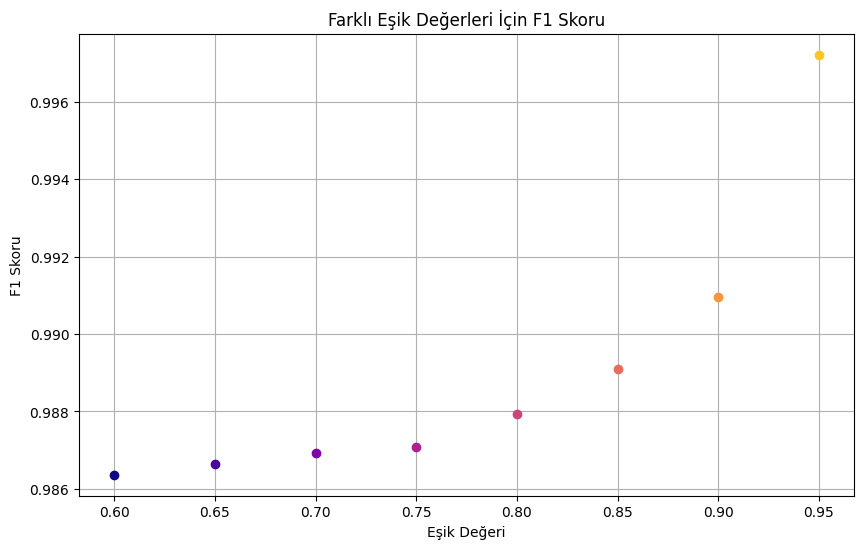

In [126]:
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

thresholds = [0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
f1_scores = []

plt.figure(figsize=(10, 6))

for i, threshold in enumerate(thresholds):
    pred_labels = (similarity_scores > threshold).astype(float)
    f1 = f1_score(true_labels, pred_labels)
    f1_scores.append(f1)

    # Farklı renkler için bir renk paleti kullan
    colors = plt.cm.plasma(i / float(len(thresholds)))

    plt.plot(threshold, f1, marker='o', color=colors)

plt.xlabel('Eşik Değeri')
plt.ylabel('F1 Skoru')
plt.title('Farklı Eşik Değerleri İçin F1 Skoru')
plt.grid(True)
plt.show()

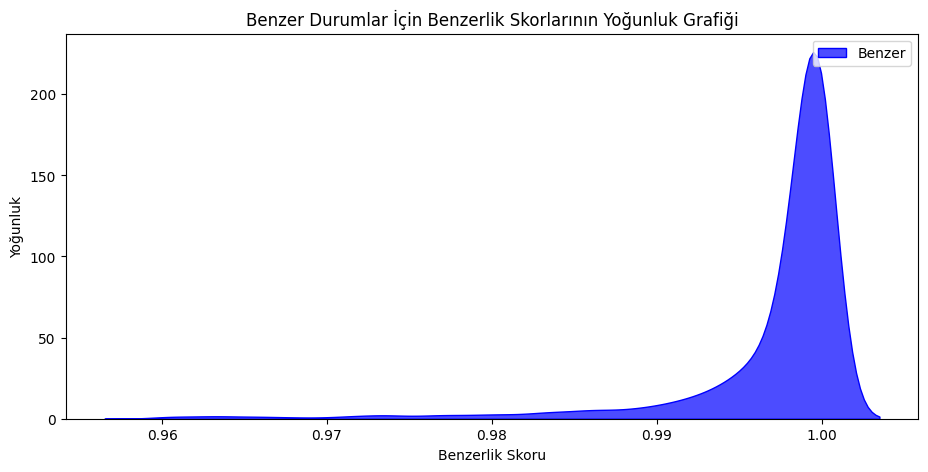

In [127]:
import seaborn as sns
import matplotlib.pyplot as plt

# Benzerlik skorlarını iki sınıfa ayır
similar_scores = similarity_scores[true_labels == 1]

plt.figure(figsize=(11, 5))
sns.kdeplot(similar_scores, label='Benzer', fill=True, color='blue', alpha=0.7)
plt.xlabel('Benzerlik Skoru')
plt.ylabel('Yoğunluk')
plt.title('Benzer Durumlar İçin Benzerlik Skorlarının Yoğunluk Grafiği')
plt.legend()
plt.show()

